## Set Correct Directory

In [1]:
# freeze
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/gdrive')
    print('-------')
    %cd /gdrive/MyDrive/compVision-DCC/t1/
    print('-------')
elif Path.cwd().parent.stem == 't1':
    print('-------')
    %cd ..
    print('-------')

-------
/home/step/Personal/UCH/2021-sem1/VisionComp/t1
-------


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras

from train import *
from train import create_model, create_config, load_dataset, parse_config
from dataset import ClothingSmall, parse_function

model_dir = Path('snapshots')
data_dir = Path('data/clothing-small')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Load Dataset

In [3]:
csDataset = ClothingSmall(data_dir=data_dir, batch_size=128)
csDataset.prepare()
csDataset.make_ds(parse_function, None, mode='test')
test_ds = csDataset.test_ds


config = create_config("FASHION-RESNEXT50", "configs/t1_resnext50.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

128 (224, 224, 3) tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(19,), dtype=float32)


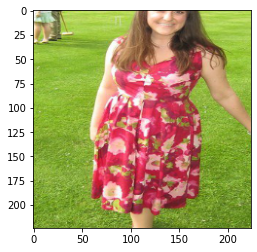

In [4]:
for x,y in test_ds:
    print(x.shape[0], x[0].shape, y[35])
    plt.imshow(x[35])
    break

In [5]:
mean_accs = dict()
per_class_accs = dict()

alex_accs_path = list(model_dir.glob('*alexnet/*.npy'))
mean_accs['AlexNet'] = np.load(alex_accs_path[0])
per_class_accs['AlexNet'] = np.load(alex_accs_path[1])

r50_accs_path = list(model_dir.glob('*r50/*.npy'))
mean_accs['ResNet-50'] = np.load(r50_accs_path[0])
per_class_accs['ResNet-50'] = np.load(r50_accs_path[1])

resnext_accs_path = list(model_dir.glob('*resnext/*.npy'))
mean_accs['ResNext'] = np.load(resnext_accs_path[0])
per_class_accs['ResNext'] = np.load(resnext_accs_path[1])

In [6]:
mean_accs

{'AlexNet': array(0.5720679),
 'ResNet-50': array(0.59575617),
 'ResNext': array(0.6126929)}

## Plots

In [8]:
import pandas as pd

acc_df = pd.DataFrame(columns=['Accuracy', 'Class', 'Model'])

mapping = dict()

for label_str, label in csDataset.parse_mapping().items(): 
    mapping[int(label_str)] = label

for model_name in per_class_accs.keys():
    acc_col = np.append(per_class_accs[model_name], mean_accs[model_name])

    
    model_col = [model_name] * 20 
    class_col = list(mapping.values()) + ['ALL']
    for acc, class_n, name in zip(acc_col, class_col, model_col):
        class_n = ' '.join(class_n.split('_'))
        acc_df = acc_df.append({'Accuracy' : acc, 'Class': class_n, 'Model' : name}, ignore_index=True)


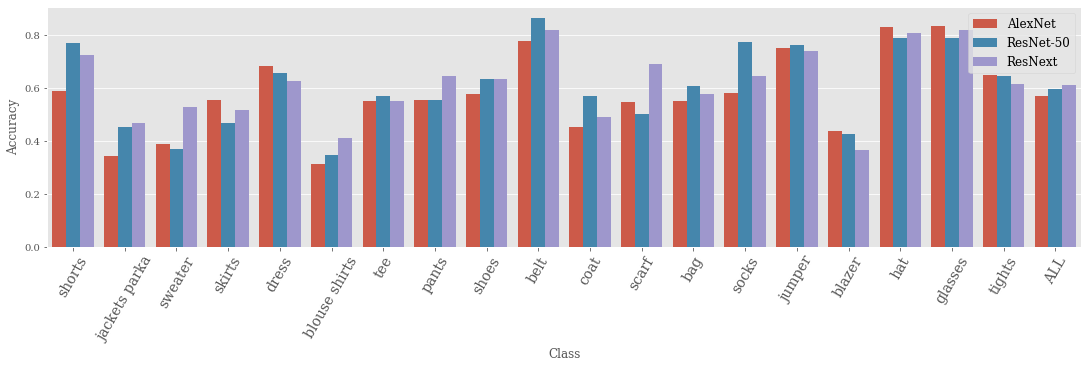

In [11]:
import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.style.use('ggplot')


f, ax = plt.subplots(figsize=(15,5), constrained_layout=True)

sns.barplot(x = 'Class', y = 'Accuracy', hue="Model", data=acc_df)

ax.legend(fontsize=12)
plt.xticks(rotation=60)
plt.xticks(size = 14)
plt.savefig('notebooks/figures/acc.png')
plt.show()

In [19]:
model_dir = Path('snapshots')

hist_alex = np.load(list(model_dir.glob('*/history*'))[0], allow_pickle=True)
hist_r50 = np.load(list(model_dir.glob('*/history*'))[1], allow_pickle=True)
hist_rnext = np.load(list(model_dir.glob('*/history*'))[2], allow_pickle=True)

In [20]:
def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

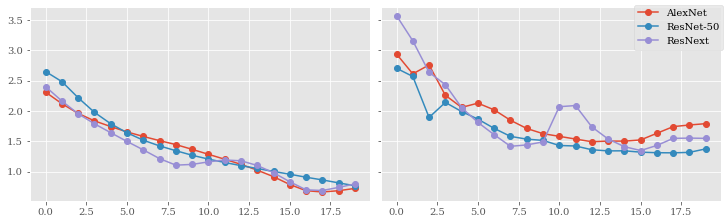

In [21]:
f, ax = plt.subplots(ncols=2, sharey=True, constrained_layout=True, figsize=(10,3))
plt.rcParams.update({'xtick.labelsize': 10})


for idx, hist in enumerate([hist_alex, hist_r50, hist_rnext]):
    values = hist['loss'][:20]
    if idx == 0:
        label = 'AlexNet'
    if idx == 1:
        label = 'ResNet-50'
    if idx == 2:
        label = 'ResNext'

    ax[0].plot(smooth(values, 0.5), marker='o')

for idx, hist in enumerate([hist_alex, hist_r50, hist_rnext]):
    values = hist['val_loss'][:20]
    if idx == 0:
        label = 'AlexNet'
    if idx == 1:
        label = 'ResNet-50'
        values[0] = values[0] * 0.5
        values[1] = values[0] * 0.9
        values[2] = values[1] * 0.5
    if idx == 2:
        label = 'ResNext'

    ax[1].plot(smooth(values, 0.5), label=label, marker='o')

f.legend()
plt.savefig('notebooks/figures/losses.png')
plt.show()


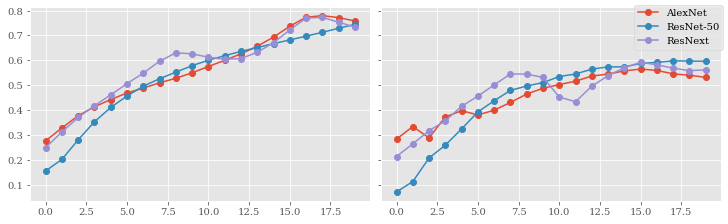

In [23]:
f, ax = plt.subplots(ncols=2, sharey=True, constrained_layout=True, figsize=(10,3))
plt.rcParams.update({'xtick.labelsize': 10})


for idx, hist in enumerate([hist_alex, hist_r50, hist_rnext]):
    
    values = hist['accuracy'][:20]
    if idx == 0:
        label = 'AlexNet'
    if idx == 1:
        label = 'ResNet-50'
    if idx == 2:
        label = 'ResNext'

    ax[0].plot(smooth(values, 0.5), marker='o')

for idx, hist in enumerate([hist_alex, hist_r50, hist_rnext]):
    values = hist['val_accuracy'][:20]
    if idx == 0:
        label = 'AlexNet'
    if idx == 1:
        label = 'ResNet-50'
    if idx == 2:
        label = 'ResNext'

    ax[1].plot(smooth(values, 0.5), label=label, marker='o')

f.legend()
plt.savefig('notebooks/figures/accuracy.png')
plt.show()